In [161]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

In [162]:
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


data_dir = Path("./datasets/others")
merge_data = pd.read_csv(data_dir / "merge-date.csv")
merge_data.set_index(
    pd.PeriodIndex(merge_data.date, freq="h"),
    inplace=True,
)

merge_data.drop("date", axis=1, inplace=True)
merge_data.drop("pm2.5", axis=1, inplace=True)
merge_data.drop("no2", axis=1, inplace=True)
merge_data.drop("no", axis=1, inplace=True)
merge_data.drop("so2", axis=1, inplace=True)
merge_data.drop("wd", axis=1, inplace=True)
merge_data.drop("ws", axis=1, inplace=True)
merge_data.drop("blh", axis=1, inplace=True)
merge_data.drop("tcc", axis=1, inplace=True)
merge_data.drop("ssrd", axis=1, inplace=True)
merge_data.drop("pop_tot", axis=1, inplace=True)
merge_data.drop("m00_30", axis=1, inplace=True)
merge_data.drop("m30_60", axis=1, inplace=True)
merge_data.drop("H1_2", axis=1, inplace=True)
merge_data.drop("H2_4", axis=1, inplace=True)
merge_data.drop("H4_8", axis=1, inplace=True)
merge_data.drop("H8_16", axis=1, inplace=True)
merge_data.drop("H16plus", axis=1, inplace=True)

merge_data_per_zip = dict(tuple(merge_data.groupby('PC4')))
merge_data_pc = merge_data_per_zip[5612]
# merge_data_pc

startdate = '2021-09-25'
enddate = '2021-09-30'

data_pc = merge_data_pc[(merge_data_pc.index >= startdate) & (merge_data_pc.index <= enddate)]
data_pc


,PC4,pm10
date,,
2021-09-25 00:00,5612,7.864758
2021-09-25 01:00,5612,5.563095
2021-09-25 02:00,5612,6.333280
2021-09-25 03:00,5612,7.906101
2021-09-25 04:00,5612,10.083385
...,...,...
2021-09-29 20:00,5612,7.078370
2021-09-29 21:00,5612,7.857697
2021-09-29 22:00,5612,7.997614


In [163]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = data_pc['pm10'].copy()
X = make_lags(y, lags=24).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=10).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

print(X)
print(y)

                   y_lag_1   y_lag_2   y_lag_3   y_lag_4   y_lag_5   y_lag_6  \
date                                                                           
2021-09-25 00:00  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-09-25 01:00  7.864758  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-09-25 02:00  5.563095  7.864758  0.000000  0.000000  0.000000  0.000000   
2021-09-25 03:00  6.333280  5.563095  7.864758  0.000000  0.000000  0.000000   
2021-09-25 04:00  7.906101  6.333280  5.563095  7.864758  0.000000  0.000000   
...                    ...       ...       ...       ...       ...       ...   
2021-09-29 11:00  4.705812  6.760188  7.982669  8.723213  7.298030  5.869226   
2021-09-29 12:00  7.745736  4.705812  6.760188  7.982669  8.723213  7.298030   
2021-09-29 13:00  6.414921  7.745736  4.705812  6.760188  7.982669  8.723213   
2021-09-29 14:00  7.397569  6.414921  7.745736  4.705812  6.760188  7.982669   
2021-09-29 15:00  4.100325  7.397569  6.

In [164]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)

y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 0.00
Test RMSE: 5.22


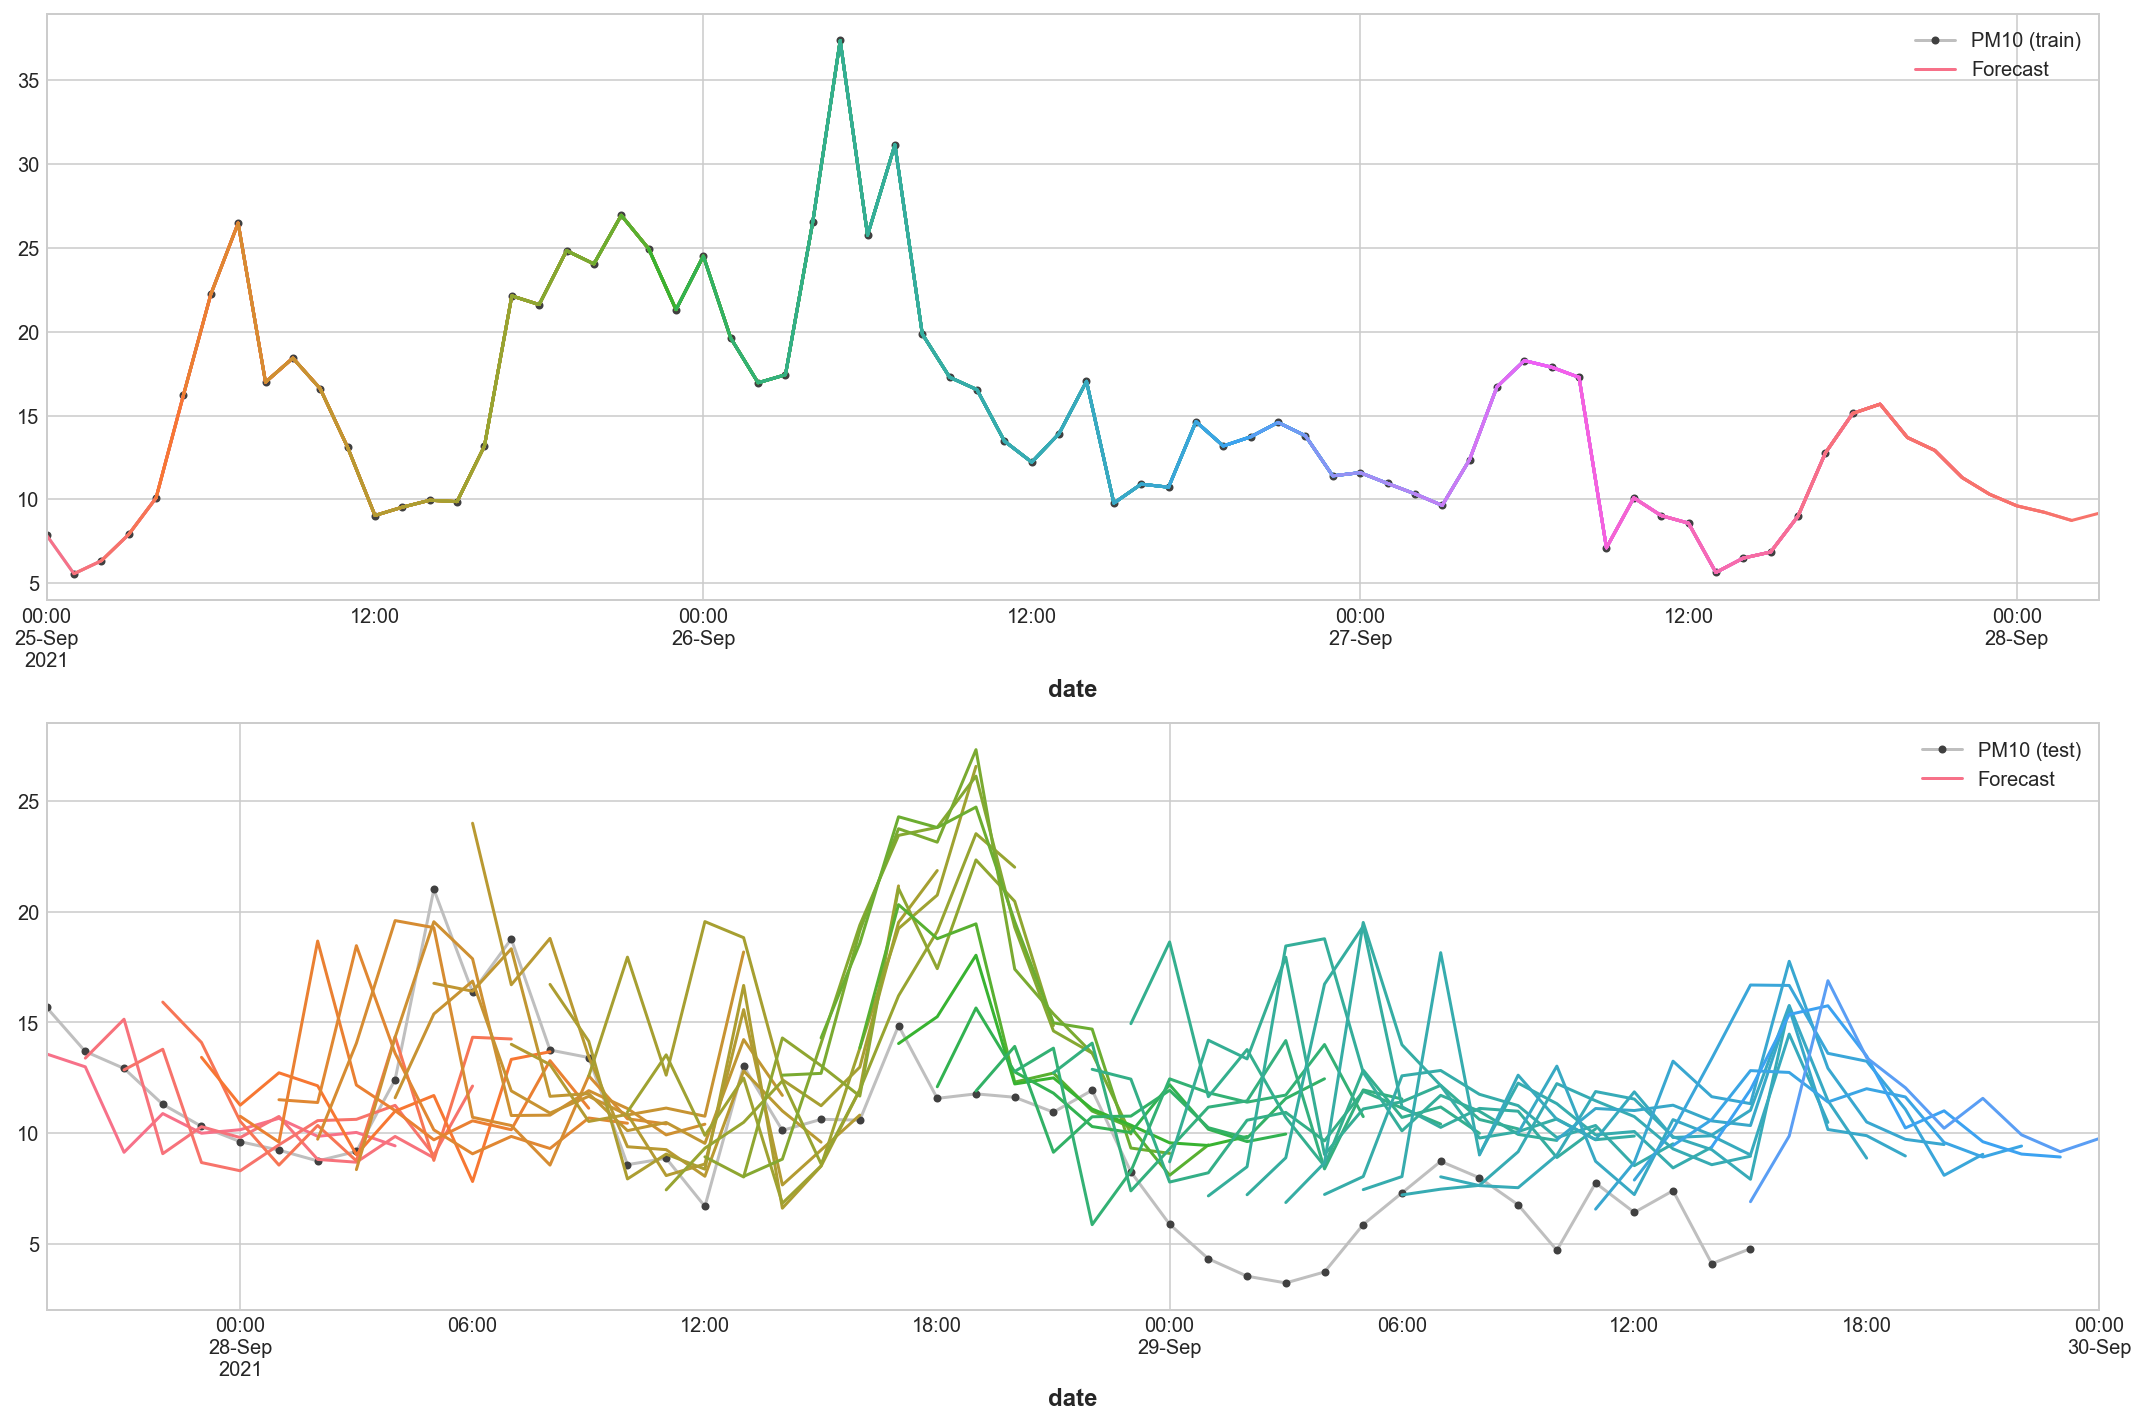

In [165]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1 = data_pc['pm10'][y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['PM10 (train)', 'Forecast'])

ax2 = data_pc['pm10'][y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['PM10 (test)', 'Forecast'])

In [166]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 4.53
Test RMSE: 5.36


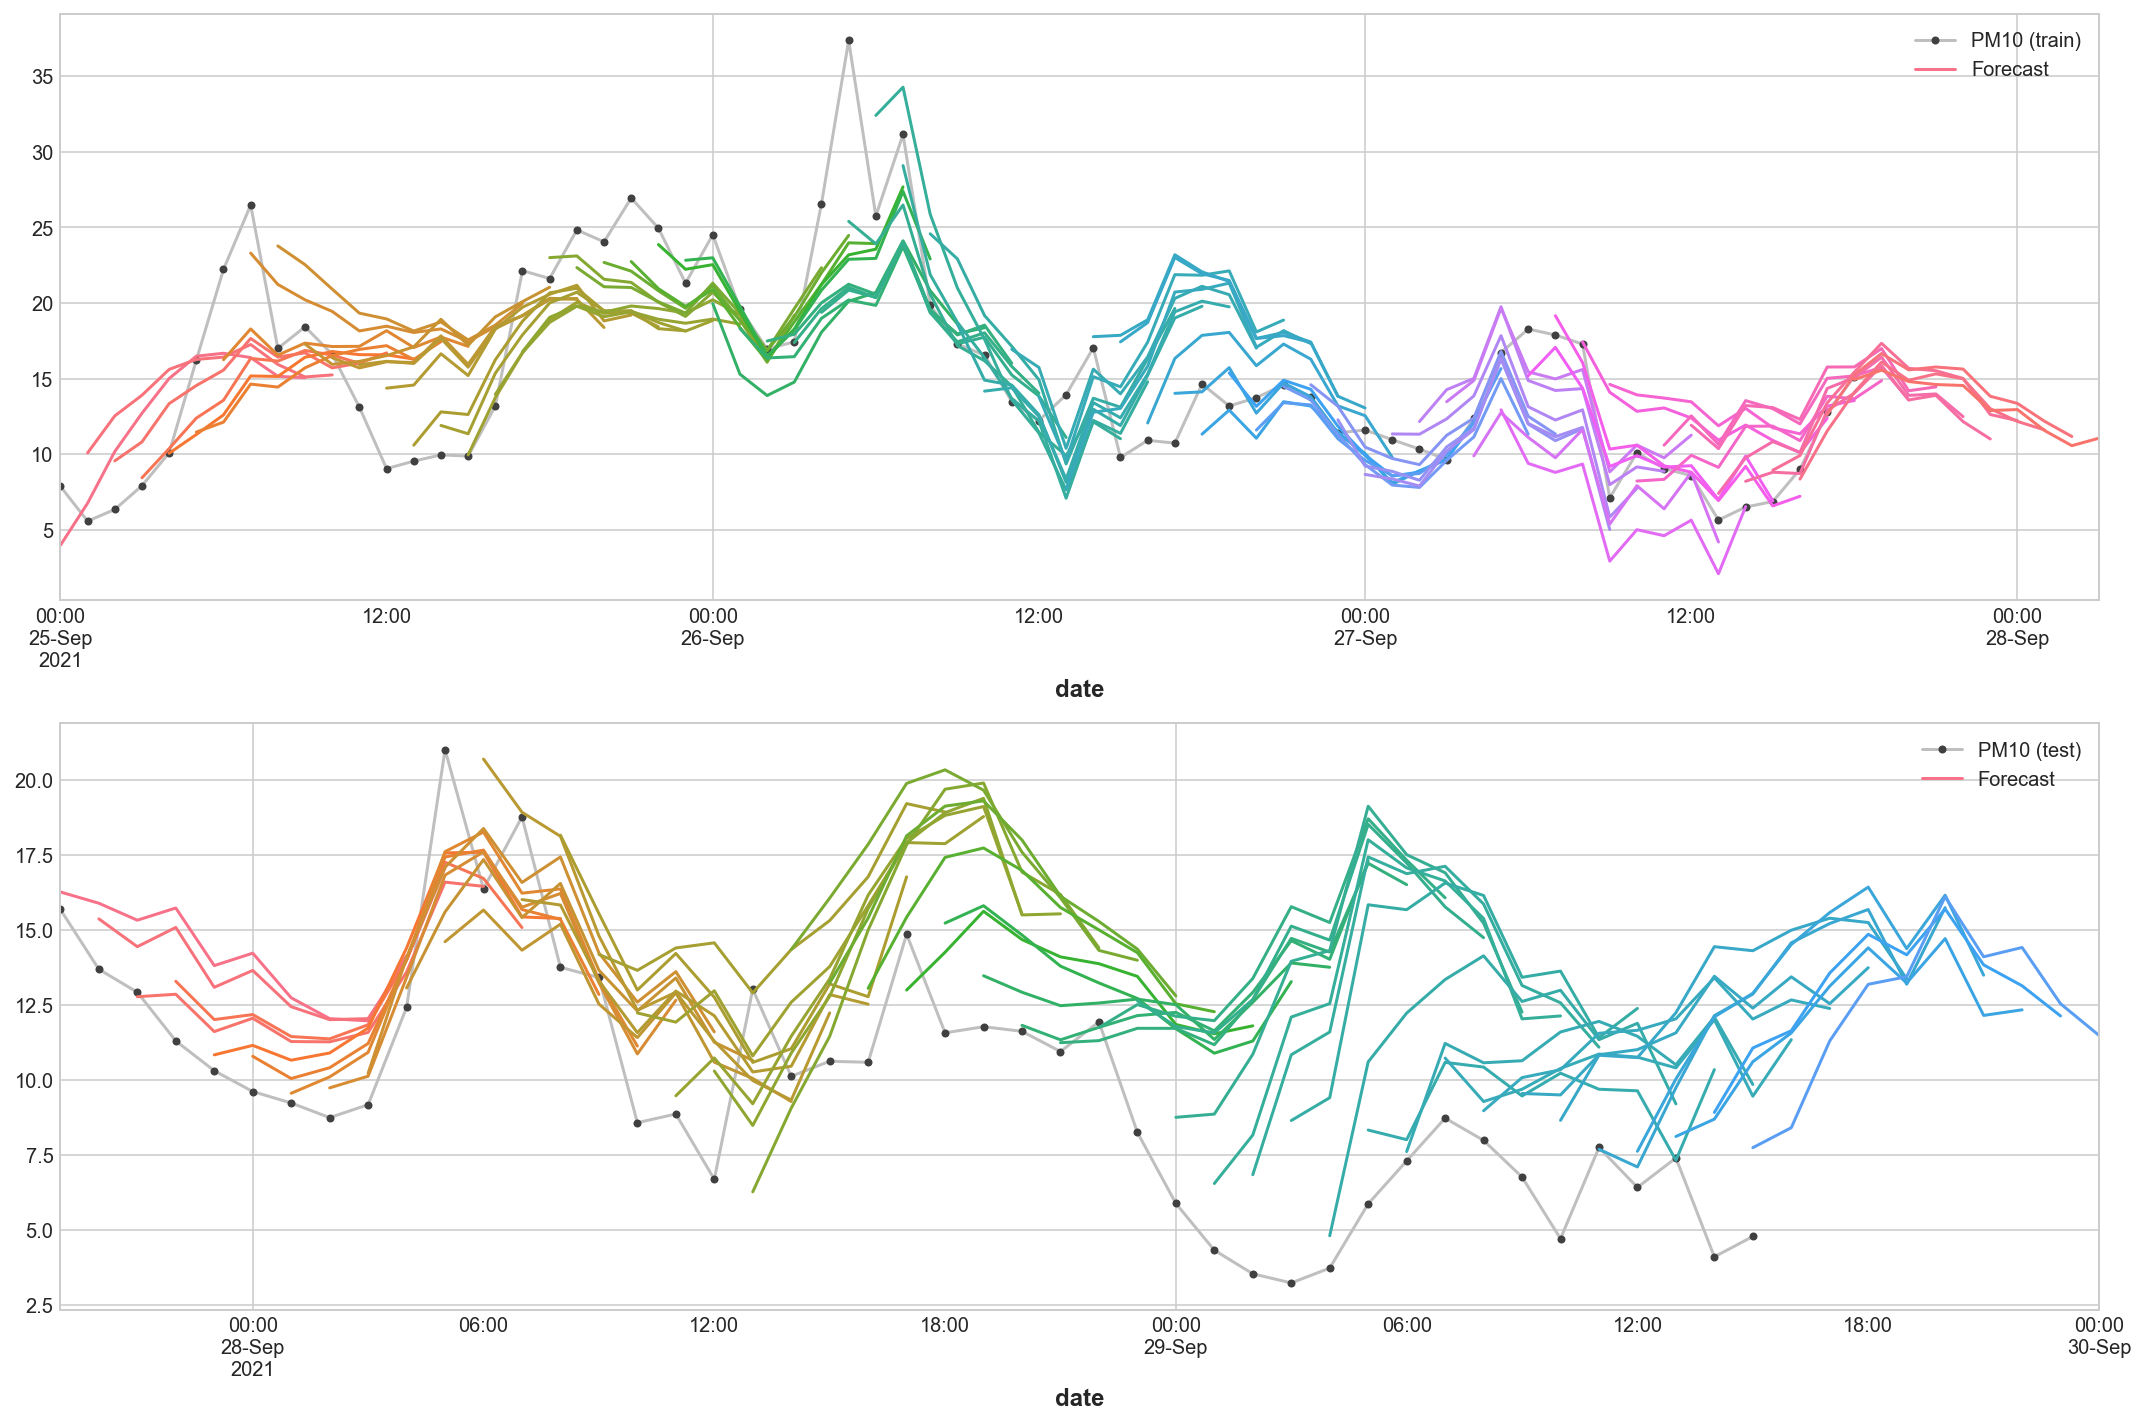

In [167]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1 = data_pc['pm10'][y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['PM10 (train)', 'Forecast'])

ax2 = data_pc['pm10'][y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['PM10 (test)', 'Forecast'])